# Exercise 6: Markov Chain Monte Carlo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from math import factorial
from collections import Counter

## 1. The number of busy lines in a trunk group (Erlang system) is given by a truncated Poisson distribution $P(i) = c\cdot \frac{A^i}{i!}, \quad i=0,\dots,m$

## Generate values from this distribution by applying the Metropolis-Hastings algorithm, verify with a χ^2-test. You can use the parameter values from exercise 4.

Here, we generate samples from the truncated Poisson distribution $P(i)$. In it, we observe that $A$ is the intensity of the traffic, $m$ is the number of available lines in the system, $c$ is a normalizing constant that ensures probabilities sum to 1, and $m$ is the number of servers.

Looking back at exercise 4, we set $m=10$ servers, and $A=8$ Erlangs.

We implement the Metropolis-Hastings algorithmn with a proposal distribution that chooses uniformly between +1 and -1 (relative to the current position). To reduce autocorrelation, we sample $20,000$ points with stride $10$ (only keeping every 10th point). Afterwards, a $\chi^2$ test is done to compare the sampled distribution with the theoretical one:

In [17]:
np.random.seed(42)

A = 8  
m = 10        

# target distribution
def g(i):
    if 0 <= i <= m:
        return A**i / factorial(i)
    return 0

Z = sum(g(i) for i in range(m + 1))
true_probs = np.array([g(i)/Z for i in range(m + 1)])    

def metropolis_hastings_1():
    num_samples = 20_000

    samples = []
    current = np.random.randint(0, m + 1)

    for _ in range(num_samples):
        proposal = current + np.random.choice([-1, 1])
        
        if 0 <= proposal <= m:
            acceptance_ratio = g(proposal) / g(current)
            if np.random.rand() < min(1, acceptance_ratio):
                current = proposal
        samples.append(current)

    samples = samples[::10]
    num_samples = num_samples // 10

    counts, bins = np.histogram(samples, bins=np.arange(-0.5, m+1.5, 1))
    estimated_probs = counts / num_samples

    chi2_stat, p_value = chisquare(counts, f_exp=true_probs * num_samples)

    return counts, estimated_probs, chi2_stat, p_value

counts, estimated_probs, chi2_stat, p_value = metropolis_hastings_1()

vals = [metropolis_hastings_1() for _ in range(100)]

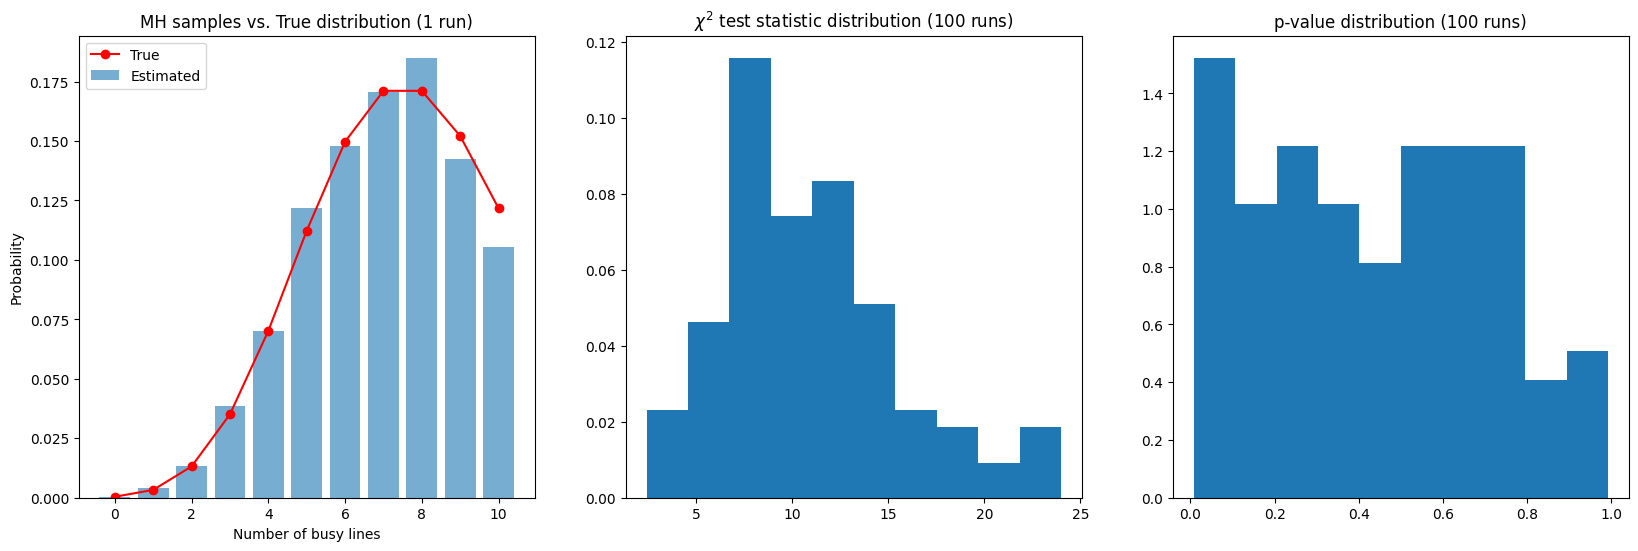

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

ax[0].bar(range(m+1), estimated_probs, alpha=0.6, label="Estimated")
ax[0].plot(range(m+1), true_probs, 'ro-', label="True")
ax[0].set_xlabel("Number of busy lines")
ax[0].set_ylabel("Probability")
ax[0].set_title("MH samples vs. True distribution (1 run)")
ax[0].legend()

ax[1].set_title(r"$\chi^2$ test statistic distribution (100 runs)")
ax[1].hist([val[2] for val in vals], density=True)

ax[2].set_title("p-value distribution (100 runs)")
ax[2].hist([val[3] for val in vals], density=True)

plt.show()

We see that the p-values are somewhat uniform, implying that the MH sampler approximates the target distribution. We have not however tested the uniformity explicitly, and even visually there seems to be some deviation from uniformity.

In our earlier experiments without the stride-tactic to reduce autocorrelation, nearly all p-values were less than 0.05.

## 2. For two different call types the joint number of occupied lines is given by $P(i,j) = c\cdot \frac{A^i _1}{i!} \frac{A^j _2}{j!}, \quad 0\leq i+j\leq m$.

## You can use A1, A2 = 4 and m = 10.
### (a) Use Metropolis-Hastings, directly to generate variates from this distribution.

## In all three cases test the distribution fit with a χ^2 test The system can be extended to an arbitrary dimension, and we can add restrictions on the different call types.




In this exercise we will need to plot many heatmaps of distributions. To reduce clutter, we define a function for this upfront:

In [41]:
def plot_solution(samples, title):

    counts = Counter(samples[0])
    heatmap = np.zeros((m+1, m+1))

    for (i, j), count in counts.items():
        heatmap[i, j] = count

    for i in range(m+1):
        for j in range(m+1):
            if i + j > m:
                heatmap[i, j] = np.nan

    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    ax[0].imshow(heatmap, origin='lower', cmap='viridis', interpolation='none')
    #ax[0].colorbar(label='Frequency')
    ax[0].set_xlabel("Number of type 2 calls (j)")
    ax[0].set_ylabel("Number of type 1 calls (i)")
    ax[0].set_title(title)
    
    p_vals = []
    chi_vals = []

    for sample in samples:
        counts = Counter(sample)
        heatmap = np.zeros((m+1, m+1))

        for (i, j), count in counts.items():
            heatmap[i, j] = count

        for i in range(m+1):
            for j in range(m+1):
                if i + j > m:
                    heatmap[i, j] = np.nan

        unnormalized = np.zeros((m+1, m+1))
        for i in range(m+1):
            for j in range(m+1):
                if i + j <= m:
                    unnormalized[i, j] = g(i, j)

        Z = np.nansum(unnormalized)
        expected_probs = unnormalized / Z
        expected_counts = expected_probs * len(sample)

        observed = []
        expected = []

        for i in range(m+1):
            for j in range(m+1):
                if i + j <= m:
                    observed.append(heatmap[i, j])
                    expected.append(expected_counts[i, j])

        chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)

        p_vals.append(p_val)
        chi_vals.append(chi2_stat)
    
    ax[1].set_title(r"$\chi^2$ test statistic distribution (100 runs)")
    ax[1].hist(chi_vals, density=True)

    ax[2].set_title("p-value distribution (100 runs)")
    ax[2].hist(p_vals, density=True)

    plt.show()


Now, we extend the blocking model to account two call types. The joint number of occupied lines is given by $P(i,j)$, where $A_1 , A_2 = 4$ and $m=10$, for $0\leq i+j \leq m$.

We use the Metropolis-Hastings algorithm to approximate the target distribution, using a proposal distribution that sets $x = x + dx$ and $y = y + dy$ where $dx$ and $dy$ are sampled uniformly and independently from $\{-1, 0, 1\}$:

In [55]:
np.random.seed(42)

A1, A2 = 4, 4
m = 10

def g(i, j):
    if 0 <= i <= m and 0 <= j <= m and i + j <= m:
        return (A1**i / factorial(i)) * (A2**j / factorial(j))
    return 0

def metropolis_hastings_2():
    num_samples = 50_000
    samples = []
    current = (0, 0)

    shifts = [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]

    for _ in range(num_samples):
        i, j = current
        shift_idx = np.random.choice(len(shifts))
        di, dj = shifts[shift_idx]
        proposal = (i + di, j + dj)
        if 0 <= proposal[0] <= m and 0 <= proposal[1] <= m and sum(proposal) <= m:
            g_current = g(i, j)
            g_proposed = g(*proposal)
            alpha = min(1, g_proposed / g_current) if g_current > 0 else 1
            if np.random.rand() < alpha:
                current = proposal
        samples.append(current)
        
    samples = samples[::10]

    return samples

samples = [metropolis_hastings_2() for _ in range(100)]

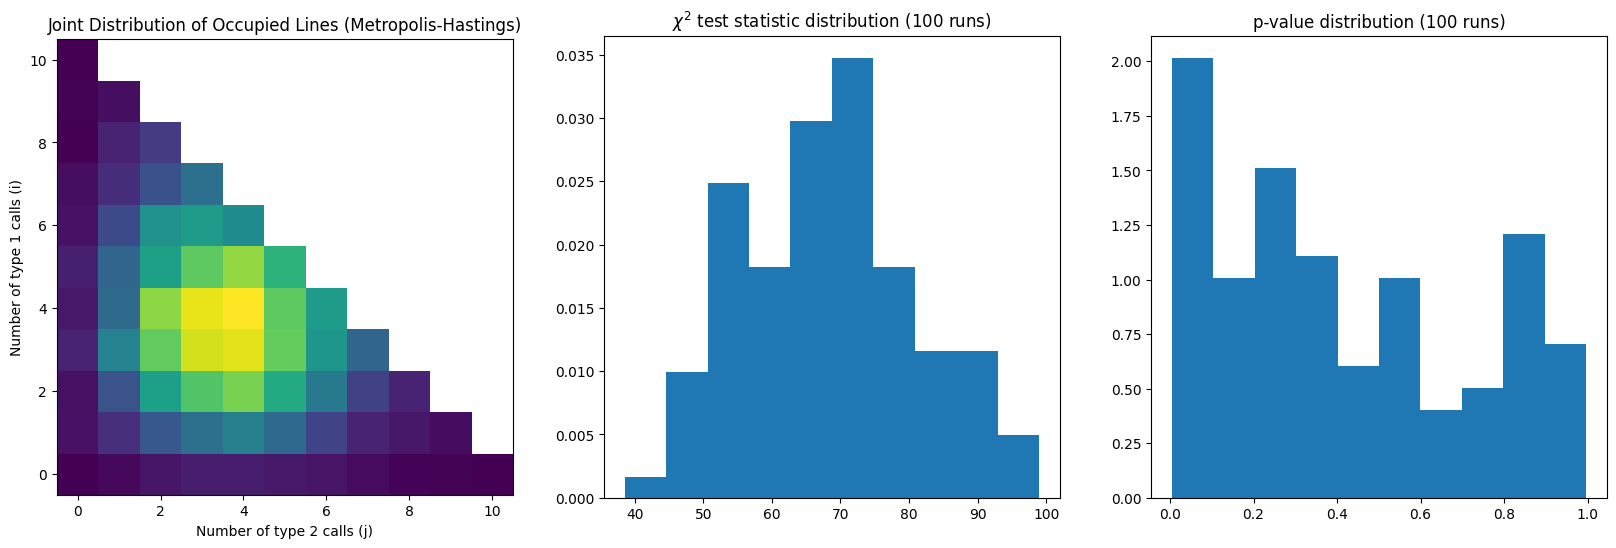

In [56]:
plot_solution(samples, "Joint Distribution of Occupied Lines (Metropolis-Hastings)")

This time the p-values mostly look uniform, but there is a noticeable peak near 0. This suggests that the algorithm fails to approximate the distribution.

### (b) Use Metropolis-Hastings, coordinate wise to generate variates from this distribution. (b) Use Metropolis-Hastings, coordinate wise to generate variates from this distribution.

Here, we implement a coordinate-wise version Metropolis-Hastings algorithm, sampling again from $P(i,j)$. This in order to generate variates from the distribution:

In [58]:
np.random.seed(42)

def metropolis_hastings_3():
    num_samples = 25_000
    samples = []
    current = [0, 0]
    shifts = [-1, 1]
    for _ in range(num_samples):
        for d in [0, 1]:  
            proposal = current[:]
            shift_idx = np.random.choice(2)
            proposal[d] += shifts[shift_idx]
            if 0 <= proposal[0] <= m and 0 <= proposal[1] <= m and sum(proposal) <= m:
                g_current = g(*current)
                g_proposal = g(*proposal)
                alpha = min(1, g_proposal / g_current) if g_current > 0 else 1
                if np.random.rand() < alpha:
                    current = proposal
        samples.append(tuple(current))

    samples = samples[::10]
    
    return samples

samples = [metropolis_hastings_3() for _ in range(100)]

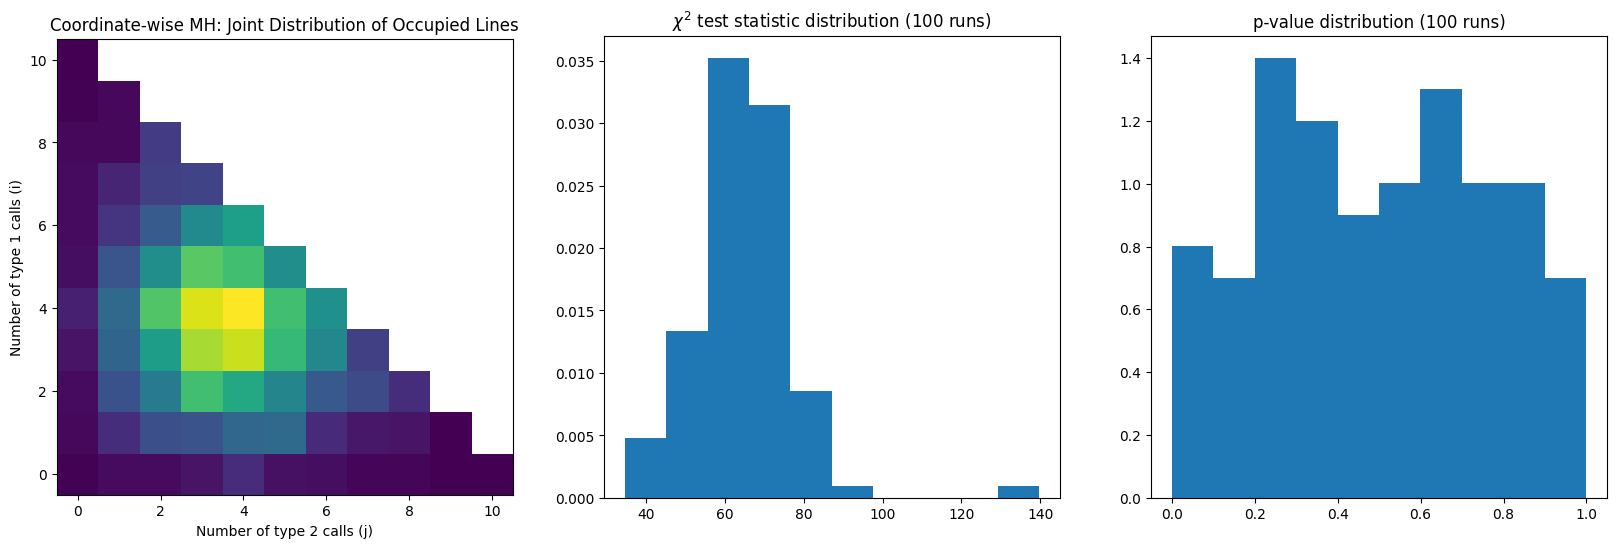

In [59]:
plot_solution(samples, "Coordinate-wise MH: Joint Distribution of Occupied Lines")

The p-values are somewhat uniform when judged visually, better than in the non-coordinate-wise version of MH.

### (c) Use Gibbs sampling to sample from the distribution. This is (also) coordinate-wise but here we use the exact conditional distributions. You will need to find the conditional distributions analytically.

Here, we use Gibbs sampling to generate samples from $P(i,j)$. We sample each variable using its exact conditional distribution. 

$$P(i) = \sum_j P(i, j) = \sum_j \frac{A_1^i}{i!}\frac{A_2^j}{j!}c = \frac{A_1^i}{i!} \sum_j \frac{A_2^j}{j!}c = \frac{A_1^i}{i!} \tilde{c}$$

We do not now the constant $\tilde{c}$ analytically, but can calculate it cheaply.

In [63]:
def gibbs_sampling():
    num_samples = 20_000
    samples = []
    i, j = 0, 0

    for _ in range(num_samples):
        
        i_max = m - j + 1
        p_vals = np.array([A1**i_candidate / factorial(i_candidate) for i_candidate in range(i_max)])
        p_vals /= np.sum(p_vals)
        i = np.random.choice(i_max, p=p_vals)

        j_max = m - i + 1
        p_vals = np.array([A2**j_candidate / factorial(j_candidate) for j_candidate in range(j_max)])
        p_vals /= np.sum(p_vals)
        j = np.random.choice(j_max, p=p_vals)

        samples.append((i, j))

    samples = samples[::10]
    return samples

samples = [gibbs_sampling() for _ in range(100)]

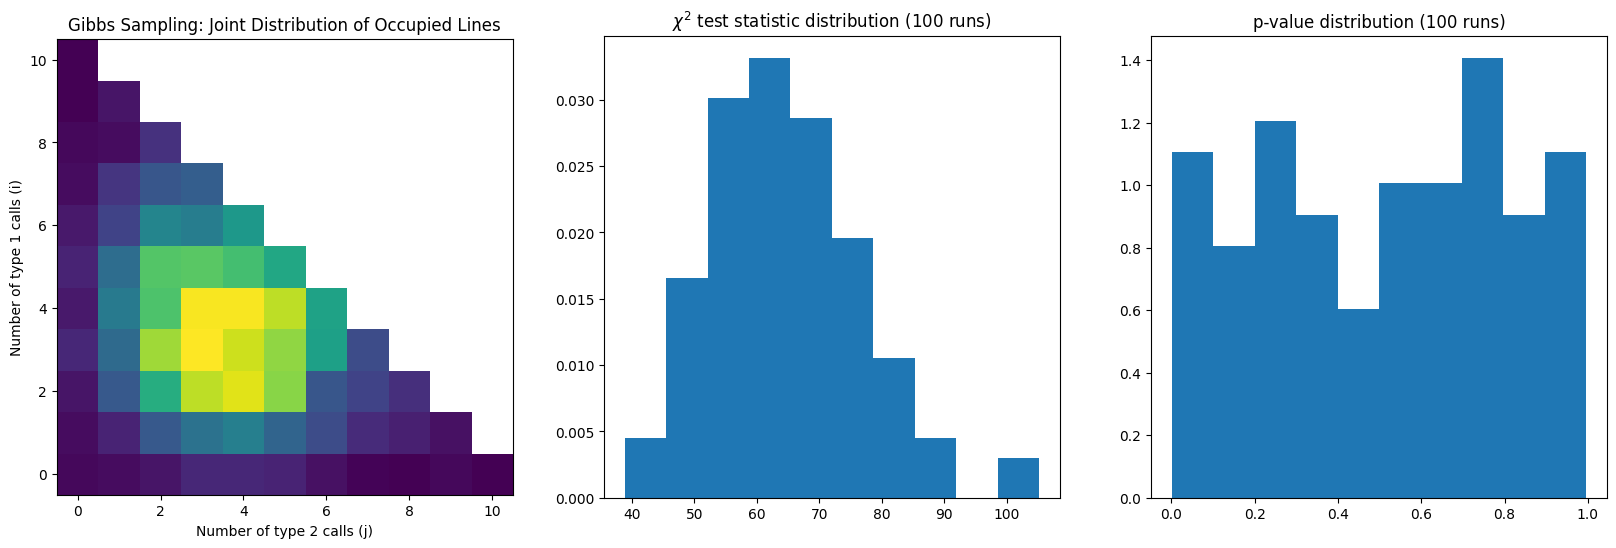

In [61]:
plot_solution(samples, "Gibbs Sampling: Joint Distribution of Occupied Lines")

The p-values are visually uniformly distributed, indicating that the Gibbs sampling successfully approximates the target dsitribution.

Gibss sampling seems to be the best solution for this specific distribution, but it of course requires that we can calculate the conditional distributions.

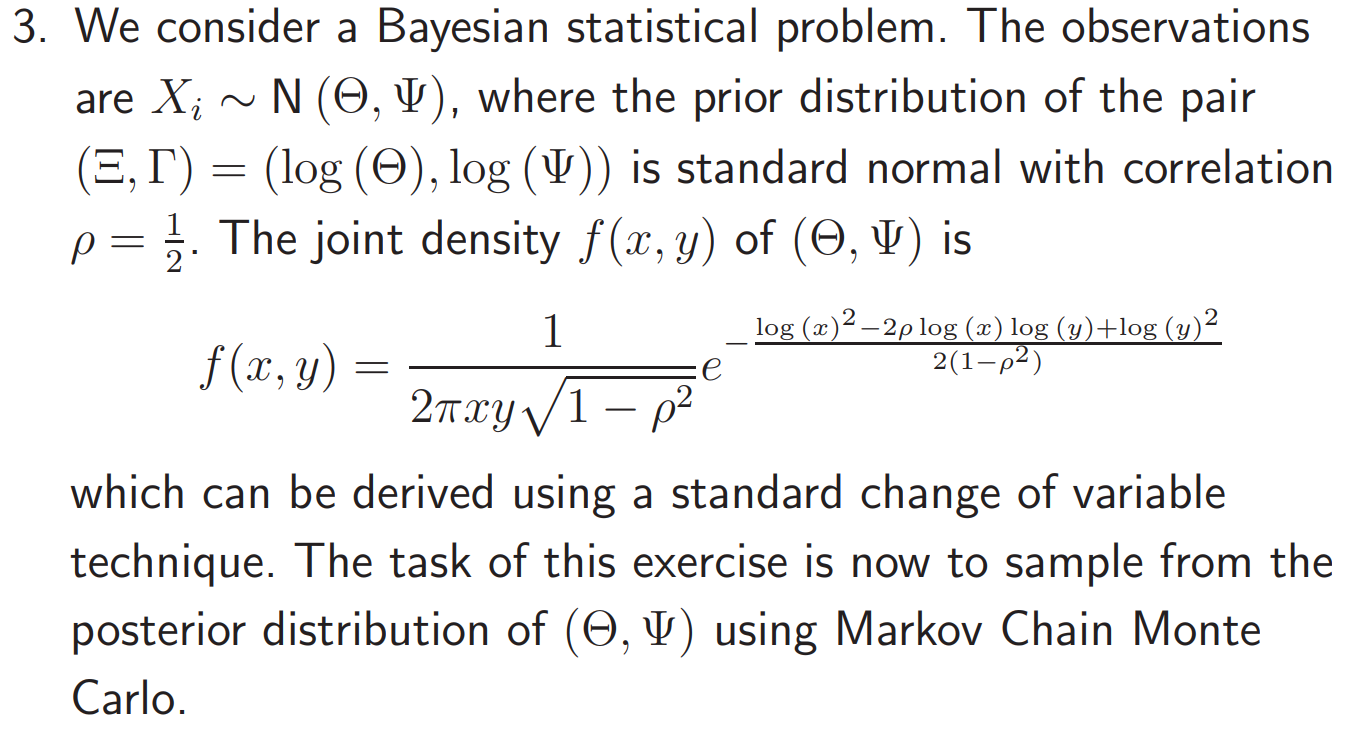

### (a) Generate a pair (θ, ψ) from the prior distribution, i.e. the distribution for the pair (Θ, Ψ), by first generating a sample (ξ, γ) of (Ξ, Γ).

Here, we generate a pair $(\theta, \psi)$ from the prior distribution, where $\log (\Theta)= \Xi$ and $\log (\Psi) = \Gamma$. The pair $(\Xi, \Gamma)$ follows a bivariate normal distribution, where the correlation is set as $\rho = 0.5$.

In order to generate a pair, first, we generate a bivariate normal sample $(\xi, \gamma)$, which we can then transform back to $(\theta, \psi)$ using
$$
\theta = e^\xi , \quad \xi = e^\theta
$$
This is as described in Day 5 slides known as the change of variable.

In [129]:
np.random.seed(1)
rho = 0.5
cov = [[1, rho], [rho, 1]]

xi_gamma = np.random.multivariate_normal(mean=[0, 0], cov=cov)
xi, gamma = xi_gamma
theta_true = np.exp(xi)
psi_true = np.exp(gamma)

print(f"Sampled ξ, γ (log(θ), log(ψ)): ({xi:.4f}, {gamma:.4f})")
print(f"Transformed θ, ψ: ({theta_true:.4f}, {psi_true:.4f})")

Sampled ξ, γ (log(θ), log(ψ)): (-1.1008, -1.7126)
Transformed θ, ψ: (0.3326, 0.1804)


The generated values $(\theta, \psi)=(0.3326, 0.1804)$ are realizations from the prior distribution. Both values are positive, meaning they are consistent with the assumed prior.

### (b) Generate Xi = 1, . . . , n with the values of (θ, ψ) you obtained in item 3a. Use n = 10.


Using the generated values, we simulate a sample of $n=10$ size from a normal distribution, where the mean is $\theta$ and the variance is $\psi$:
$$
X_i \sim \text{N}(\theta, \psi)
$$

In [130]:
n = 10

np.random.seed(42)
X = np.random.normal(loc=theta_true, scale=np.sqrt(psi_true), size=n)

print("Generated X values:")
print(np.round(X, 4))

Generated X values:
[0.5436 0.2739 0.6077 0.9795 0.2331 0.2331 1.0033 0.6585 0.1332 0.563 ]


These 10 generated values represent the synthetic observations drawn under the prior parameter.

### (c) Derive the posterior distribution of (Θ, Ψ) given the sample. Hint 1: Apply Bayes theorem in the density version. Hint 2: The sample mean and sample variance are independent. The sample mean follows a normal distribution, while a scaled version of the sample variance follows a χ 2 distribution. This can be used to simplify the expression.

In order to derive the posterior distribution, we utilize Bayes' Theorem:
$$
\text{Posterior}\propto \text{Prior}\times\text{Likelihood}
$$
Specifically for this case, it will be:
$$
\text{Posterior}(\theta, \psi|X)\propto \text{Prior}(\theta, \psi)\times\text{Likelihood}(X|\theta, \psi)
$$

From the slides, we observe:
- $\bar{X} \sim \text{N}(\Theta, \Psi / n)$
- $\frac{(n-1)S^2}{\Psi}\sim\chi^2 _{n-1}$

Using this information, gives us the factored likelihood:
$$
L(\theta, \psi)\propto \psi ^{-\frac{n}{2}} \exp(-\frac{n(\bar{x}-\theta)^2}{2\psi}-\frac{(n-1)S^2}{2\psi})
$$

The posterior is then the product of the likelihood above, and the prior.

This allows us to generate MCMC samples.

### (d) Generate MCMC samples from the posterior distribution of (Θ, Ψ) using the Metropolis Hastings method.

In order to generate MCMC samples, we use the Metropolis-Hastings algorithm, sampling from the posterior distribution $(\Theta, \Psi)$. 

We define the posterior using the log-likelihood of $\bar{X}$ and $S^2$, and the log-prior of the bivariate normal density. We use the Metropolis-Hastings with a proposal distribution of $\mathcal{N}(0, 0.2^2)$:

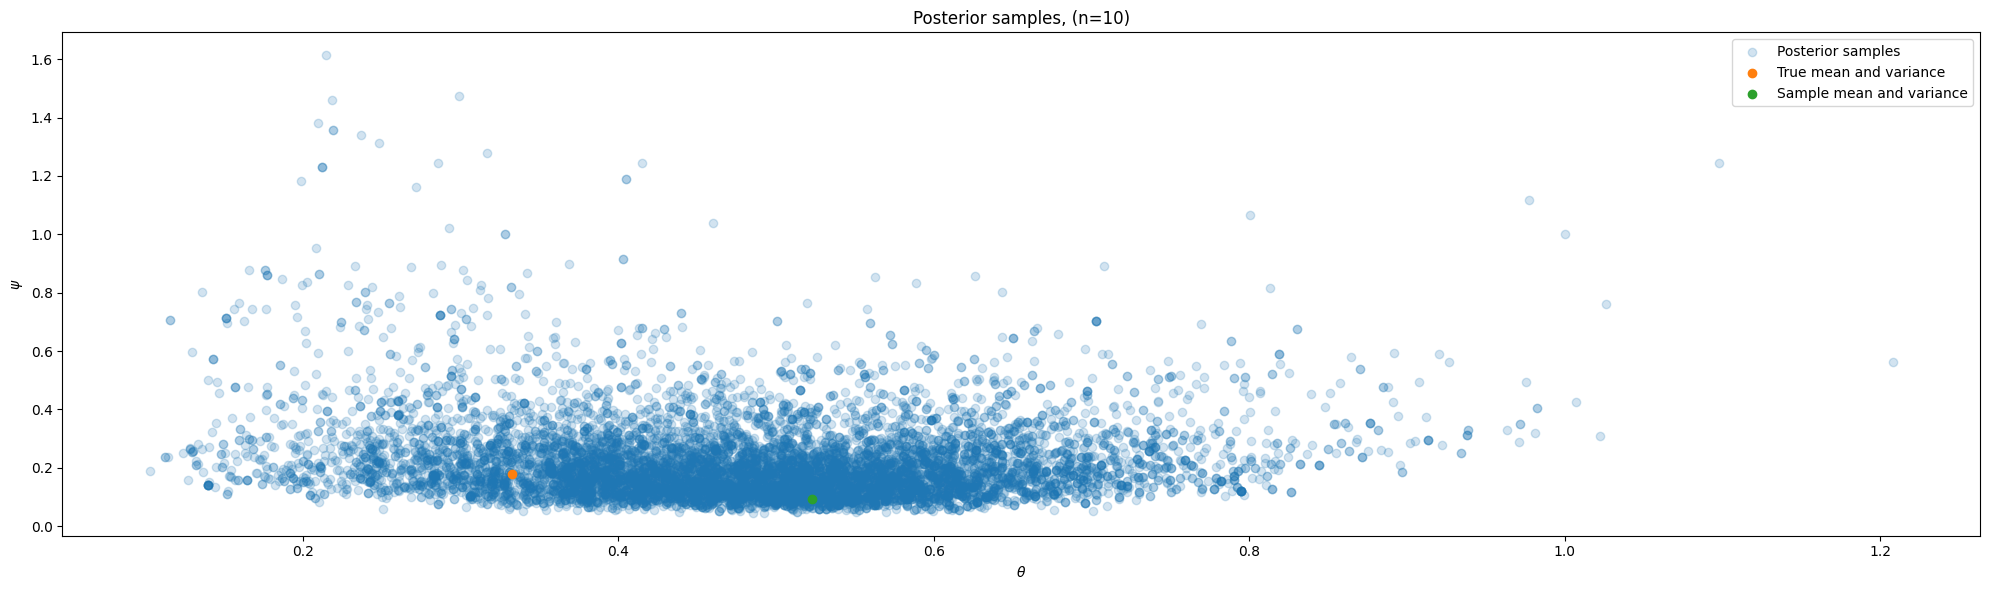

In [152]:
np.random.seed(42)

x_bar = np.mean(X)
s2 = np.var(X, ddof=1)

def log_posterior(xi, gamma):
    theta = np.exp(xi)
    psi = np.exp(gamma)
    log_like = -n / 2 * np.log(psi) - (n * (x_bar - theta)**2 + (n - 1) * s2) / (2 * psi)
    log_prior = -(xi**2 - 2 * rho * xi * gamma + gamma**2) / (2 * (1 - rho**2))
    return log_like + log_prior

num_samples = 10000
samples = []
current = np.array([0.0, 0.0]) 
step_size = 0.2

for _ in range(num_samples):
    proposal = current + np.random.normal(scale=step_size, size=2)
    log_p_current = log_posterior(*current)
    log_p_proposal = log_posterior(*proposal)
    alpha = min(1, np.exp(log_p_proposal - log_p_current))
    if np.random.rand() < alpha:
        current = proposal
    samples.append(np.exp(current)) 

samples = np.array(samples)
theta_samples = samples[:, 0]
psi_samples = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.scatter(theta_samples, psi_samples, alpha=0.2, label="Posterior samples")
ax.scatter(theta_true, psi_true, label="True mean and variance")
ax.scatter(x_bar, s2, label="Sample mean and variance")
ax.set_title("Posterior samples, (n=10)")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\psi$")
ax.legend()

plt.tight_layout()
plt.show()

The posterior is centered around the sample mean and variance, but with high uncertainty. Given the low amount of data, the prior will dominate (even though it is rather weak), and the high uncertainty is therefore expected.

The posterior of $\Psi$ is also right skewed (positive y-direction). This is consistent with an inverse-$\chi^2$ posterior, as suggested in the previous assignment.

### (e) Repeat item 3d with n = 100 and n = 1000, still using the values of (θ, ψ) from item 3a. Discuss the results.

We repeat the posterior sampling, but now setting $n=100$ and $n=1000$.

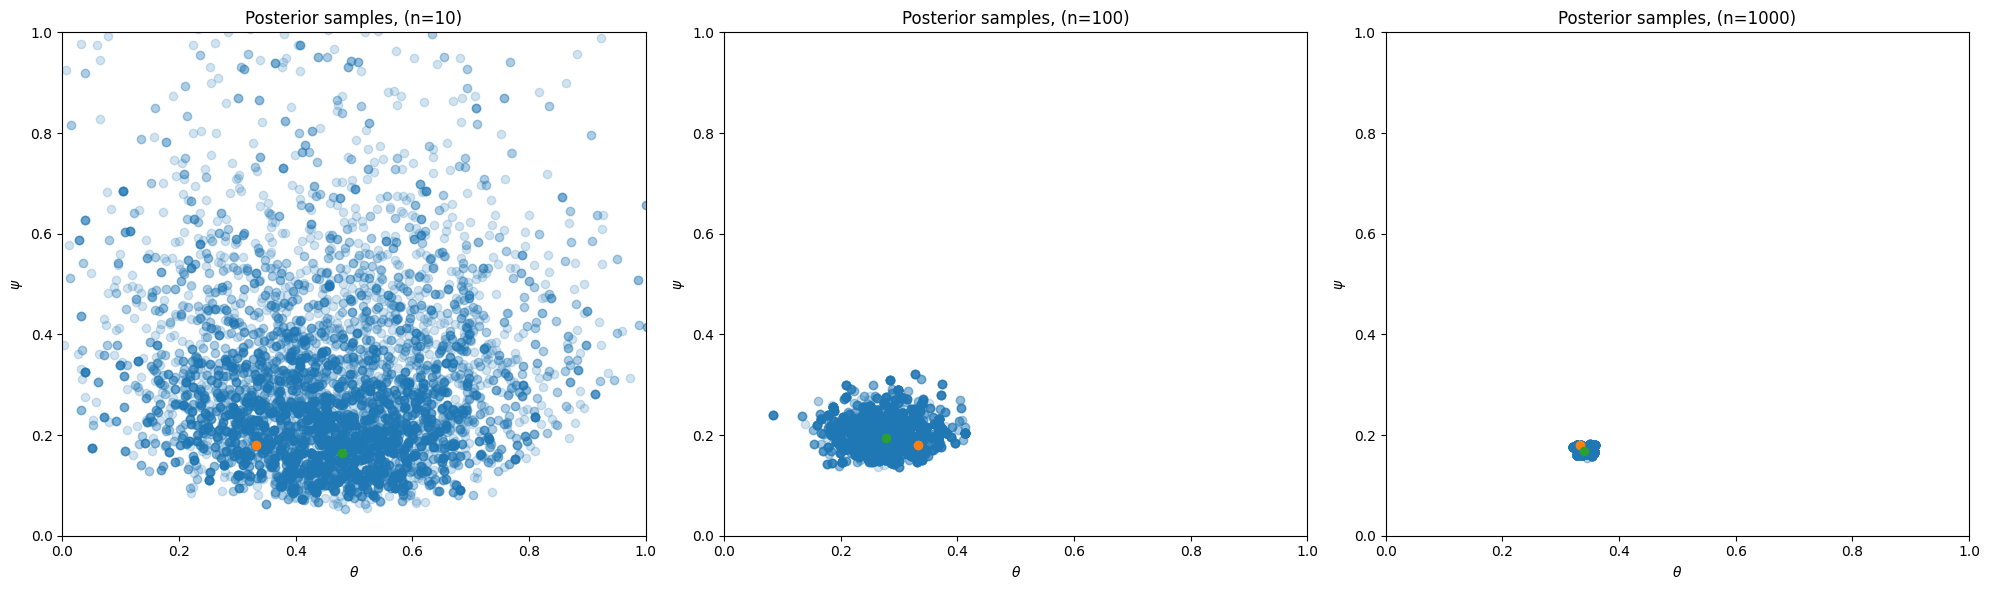

In [153]:
np.random.seed(69)

def simulate_and_sample(n, num_samples=10000, step_size=0.2):
    X = np.random.normal(loc=theta_true, scale=np.sqrt(psi_true), size=n)

    x_bar = np.mean(X)
    s2 = np.var(X, ddof=1)

    def log_posterior(theta, psi):
        if theta < 0 or psi <= 0:
            return -np.inf
        log_like = -n / 2 * np.log(psi) - (n * (x_bar - theta)**2 + (n - 1) * s2) / (2 * psi)
        log_prior = -(theta**2 - 2 * rho * theta * psi + psi**2) / (2 * (1 - rho**2))
        return log_like + log_prior

    current = np.array([1.0, 1.0])
    samples = []

    for _ in range(num_samples):
        proposal = current + np.random.normal(scale=step_size, size=2)
        log_p_current = log_posterior(*current)
        log_p_proposal = log_posterior(*proposal)
        alpha = min(1, np.exp(log_p_proposal - log_p_current))
        if np.random.rand() < alpha:
            current = proposal
        samples.append(current)

    samples = np.array(samples)
    return samples[num_samples//10:, 0], samples[num_samples//10:, 1], (x_bar, s2)


theta_10, psi_10, s_10 = simulate_and_sample(n=10)
theta_100, psi_100, s_100 = simulate_and_sample(n=100)
theta_1000, psi_1000, s_1000 = simulate_and_sample(n=1000)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

ax[0].scatter(theta_10, psi_10, alpha=0.2, label="Posterior samples")
ax[0].scatter(theta_true, psi_true, label="True mean and variance")
ax[0].scatter(*s_10, label="True mean and variance")
ax[0].set_title("Posterior samples, (n=10)")
ax[0].set_xlabel(r"$\theta$")
ax[0].set_ylabel(r"$\psi$")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

ax[1].scatter(theta_100, psi_100, alpha=0.2, label="Posterior samples")
ax[1].scatter(theta_true, psi_true, label="True mean and variance")
ax[1].scatter(*s_100, label="Sample mean and variance")
ax[1].set_title("Posterior samples, (n=100)")
ax[1].set_xlabel(r"$\theta$")
ax[1].set_ylabel(r"$\psi$")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

ax[2].scatter(theta_1000, psi_1000, alpha=0.2, label="Posterior samples")
ax[2].scatter(theta_true, psi_true, label="True mean and variance")
ax[2].scatter(*s_1000, label="Sample mean and variance")
ax[2].set_title("Posterior samples, (n=1000)")
ax[2].set_xlabel(r"$\theta$")
ax[2].set_ylabel(r"$\psi$")
ax[2].set_xlim(0, 1)
ax[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

As $n$ increases, we see the distributions become narrower and more concentrated around the sample mean and variance, which corresponds to the likelihood dominating the prior as the amount of data increases.